In [37]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 

data_dir = '/blue/stevenweisberg/share/catscenes/data/individualAnalogData/'

files = glob.glob(data_dir + '*tuning*16*.csv',recursive=True)


In [39]:
def reformat_data(file_name):
    
    # Grab the subject ID from the filename
    subj_id = file_name.split('/')[-1][:5]
    
    # Transpose the table so we can use the image names as an index
    processed_data = pd.read_csv(file_name).transpose()
    
    # Drop the images that have no data (subjects did not provide responses to all images; only 100/500)
    #processed_data.dropna(inplace=True)
    # Reformat the index into a multi-index to refer to each image as its name and subject id
    processed_data = pd.concat({subj_id : processed_data}, names=['participant','image'])
    
    return processed_data

# Load the first data file
all_data = reformat_data(files.pop(0))

# For the rest of the files, add them to the whole dataset
for file in files:
    
    subj_data = reformat_data(file)
    all_data = pd.concat([all_data,subj_data])

display(all_data.shape)

(35000, 15)

In [29]:
ling_data = pd.read_csv('/blue/stevenweisberg/share/catscenes/data/lingDirections.csv')
ling_data = ling_data[['presentedImage','sharp_left','left','slight_left','ahead','slight_right','right','sharp_right']]
display(all_data.head())

0   1   2   3   4   5   6   7   8   9   ...  \
participant image                                                       ...   
44401       ATM1.jpg           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
            ATM4.jpg           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
            HorseRaceTrack.jpg NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
            RVinside2.jpg      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   
            ShowJumping7.jpg   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   

                                26  27  28  29  30  31  32  33  34  35  
participant image                                                       
44401       ATM1.jpg           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
            ATM4.jpg           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
            HorseRaceTrack.jpg NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
            RVinside2.jpg      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
            ShowJumping7.jpg   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 36 columns]

In [40]:
from matplotlib.pyplot import cm

def process_tuning_curves(image_name,
                          df,
                          ling_df,
                          im_dir=f'/blue/stevenweisberg/share/catscenes/BOLD5000_Stimuli_Shared/Image_List_All/',
                          method='pearson',
                          show_plots=False,
                          save_plots=False,
                          out_dir='.',
                          verbose=False,):
    '''
    Takes in the name of an image and plots all tuning curves from each participant
    for that image. 
    
    image_name - string. The name of the image to plot
    df - dataframe generated by the functions above where each entry is the tuning curve data for each subject.

    '''
    
    # Slice just the image data from the df
    image_data = df.xs(image_name, level=1, drop_level=False)
    
    if image_name in ling_df['presentedImage'].values:  
        ling_data = ling_df[ling_df['presentedImage']==image_name].iloc[0,]
        
    else:
        ling_data = pd.DataFrame(data=[[image_name,0,0,0,0,0,0,0]],columns=ling_df.columns).iloc[0,]
        print(image_name)
        
        
    n = image_data.dropna().shape[0]
    color = cm.jet(np.linspace(0, 1, n))
    
    if show_plots or save_plots:
        # Create a figure
        fig, ax = plt.subplots(3,1,figsize=[6,14])
        # Add in the bar plot
        ax[2].bar(ling_df.columns[1:],ling_data[1:],width=1)
        
        
        
    # For each non-nan row (not every subject responded to every image)
    for i,c in zip(range(n),color):

        if show_plots or save_plots:
            # Plot the actual image
            ax[0].imshow(mpimg.imread(os.path.join(im_dir,f'{image_name}')))
                                    
            # Plot the analog data (individual subjects)
            ax[1].plot(image_data.dropna().iloc[i,:], color=c)
            
    # The correlation of each row of that dataframe with every other row
    corr_value = image_data.dropna().corrwith(image_data.dropna().iloc[0], axis=1,method=method)
    
    # Exclude the correlation of that row with itself
    corr_value = corr_value[1:]
    mean_corr = round(corr_value[:].mean(),2)

    if verbose:
        print(f'r-value for {image_name} = {mean_corr:.2f}')
    
    if show_plots or save_plots:
        # Format plots
        #ax[0].title.set_text('Image')
        ax[0].axis('off')

        #ax[1].title.set_text('Analog Data')
        ax[1].set_xlabel('Bin number')
        ax[1].set_ylabel('Proportion of responses')
        maxY = ax[1].get_ylim()[1]
        ax[1].annotate(f'{method} correlation = {mean_corr:.2f}',xy=(0,maxY),xytext=(0,maxY))
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
        
        #ax[2].title.set_text('Categorical Data')
        ax[2].set_xlabel('Spatial direction term')
        ax[2].set_ylabel('Proportion of responses')
        ax[2].spines['right'].set_visible(False)
        ax[2].spines['top'].set_visible(False)
    
    if save_plots:
        fig.savefig(os.path.join(out_dir,f'{method}_{mean_corr:.2f}_{image_name[:-4]}_ind_sub_plots.png'))
        
    if show_plots:
        plt.show()
    else:
        plt.close()

            
    return mean_corr


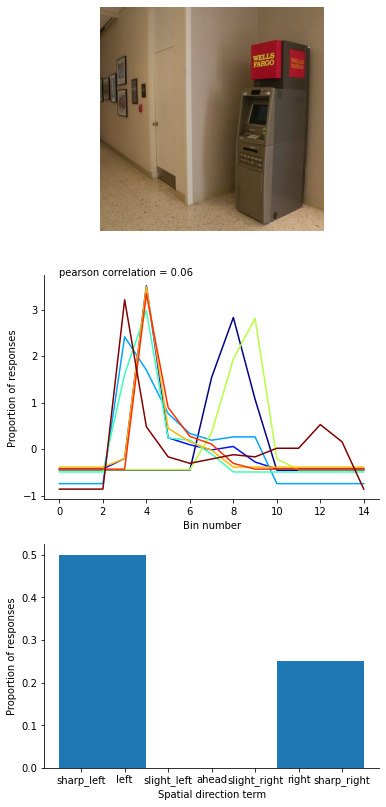

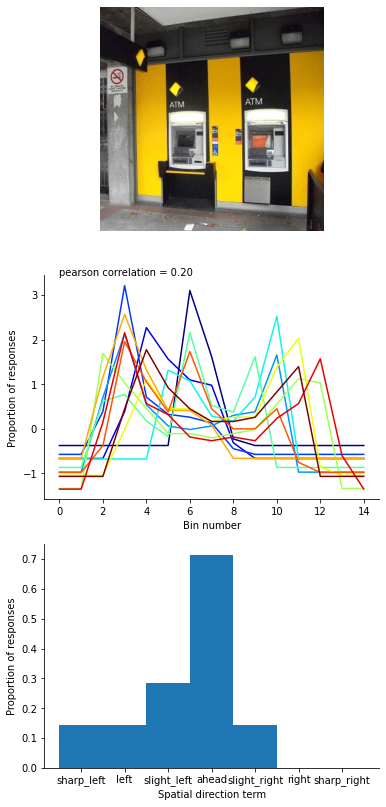

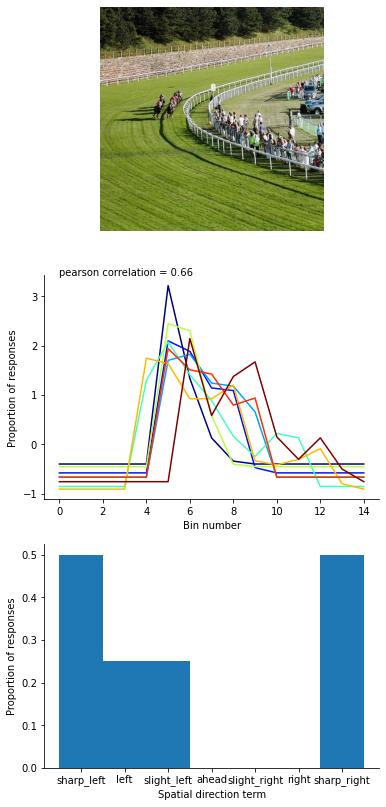

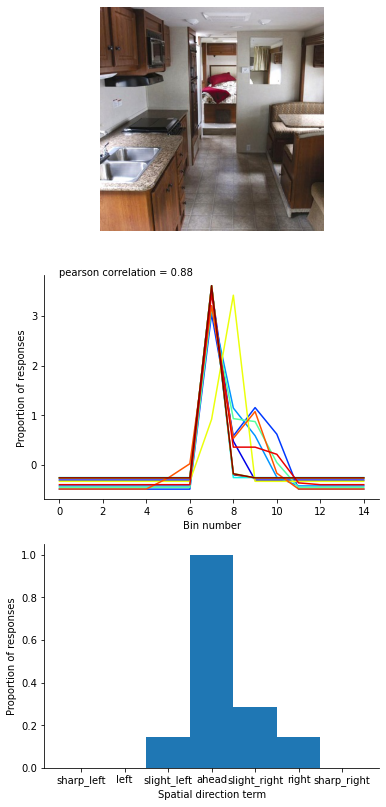

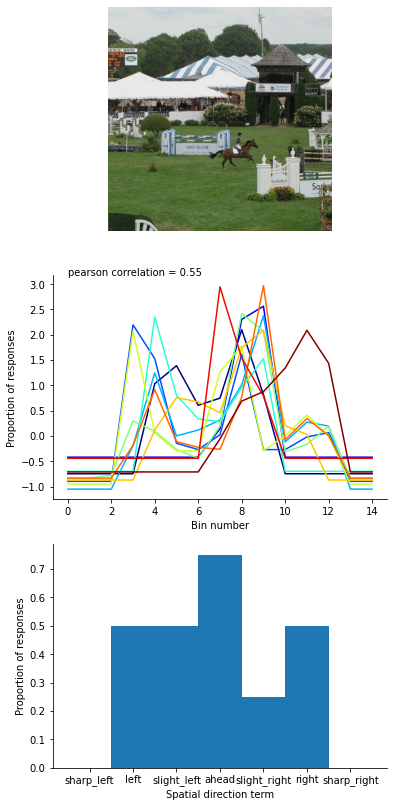

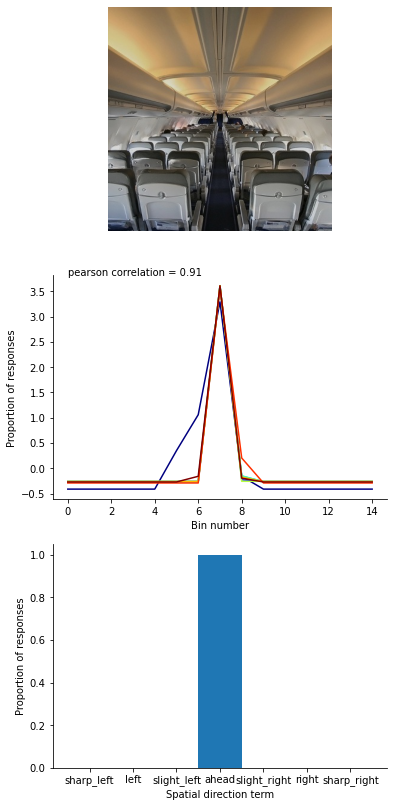

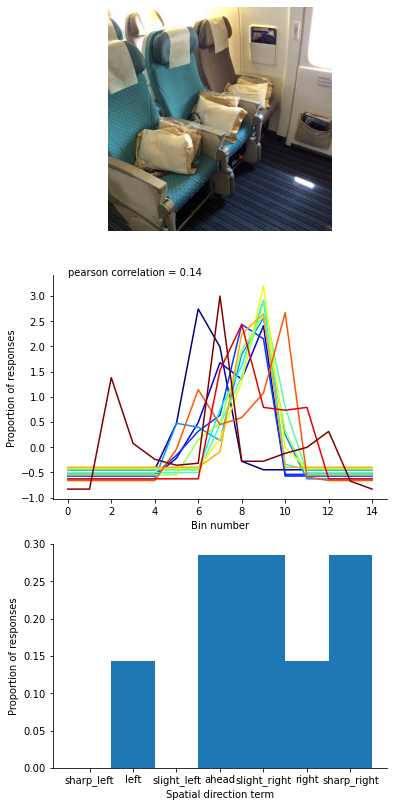

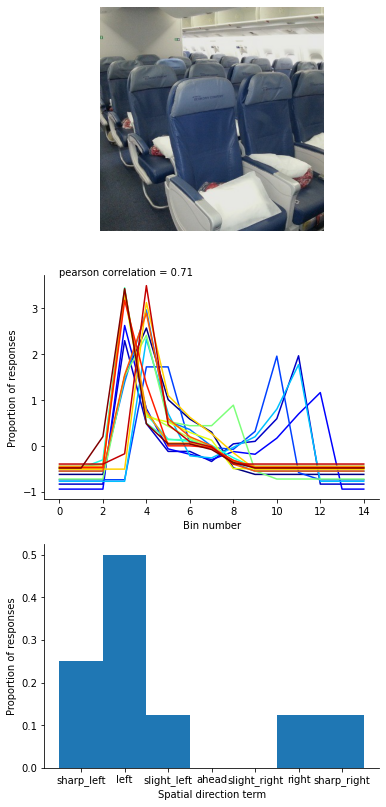

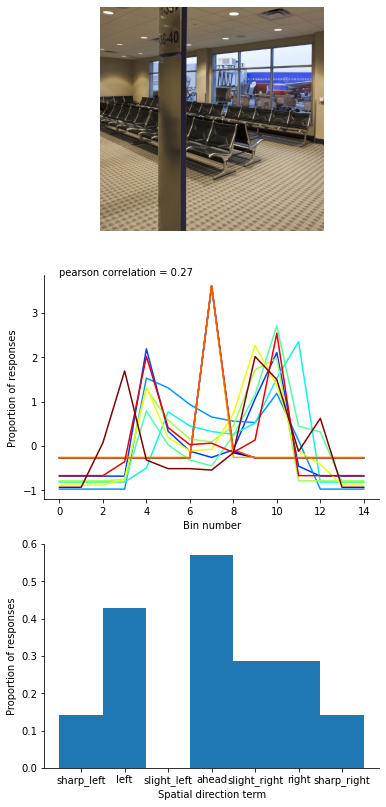

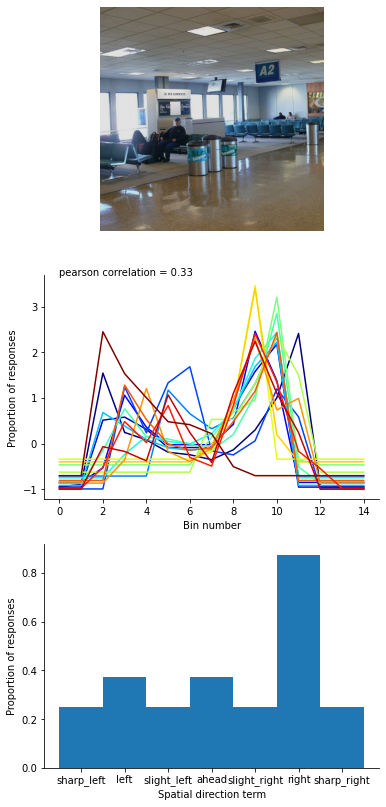

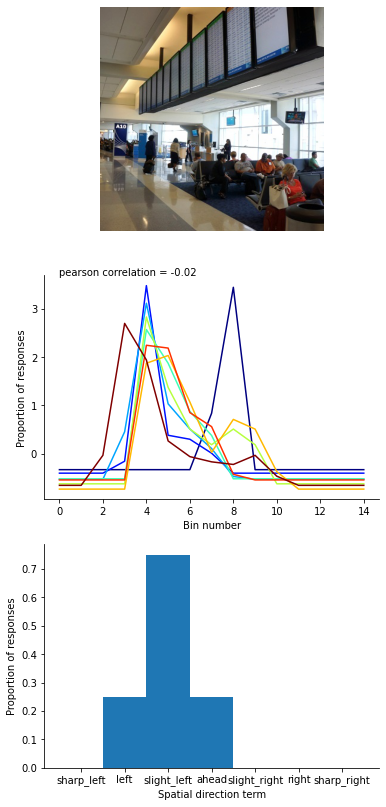

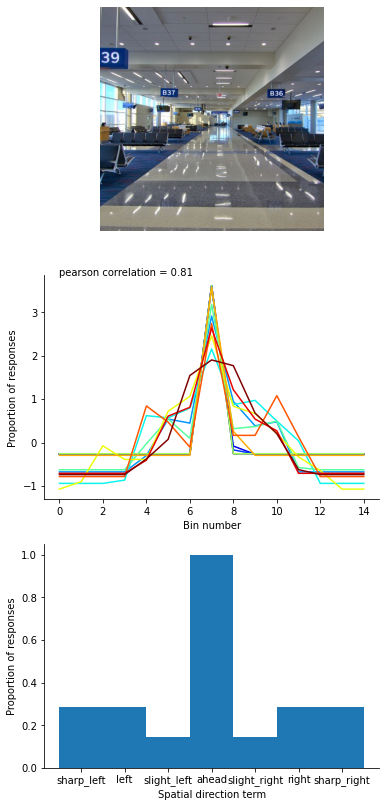

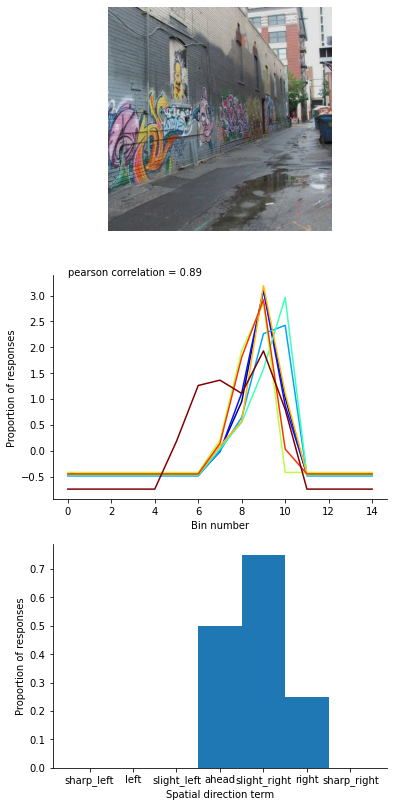

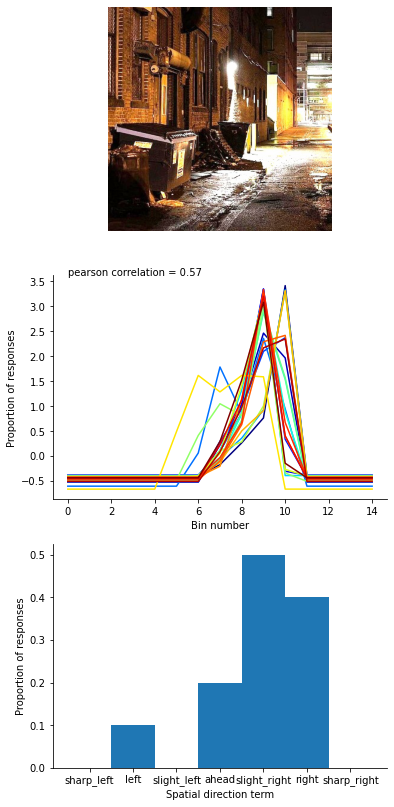

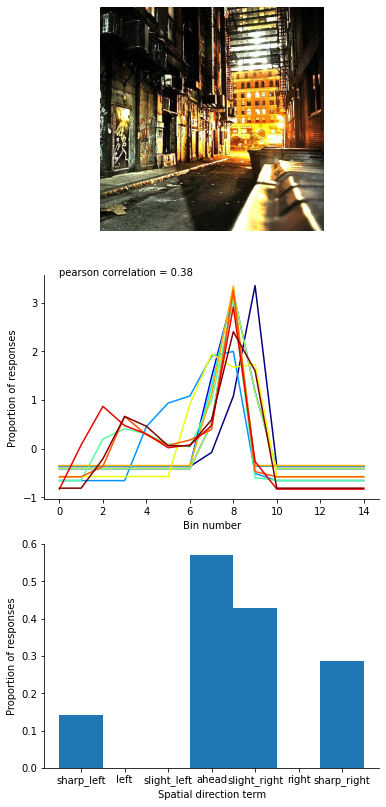

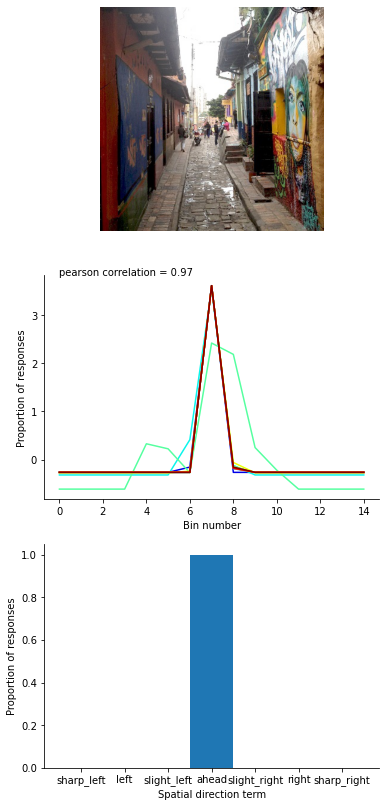

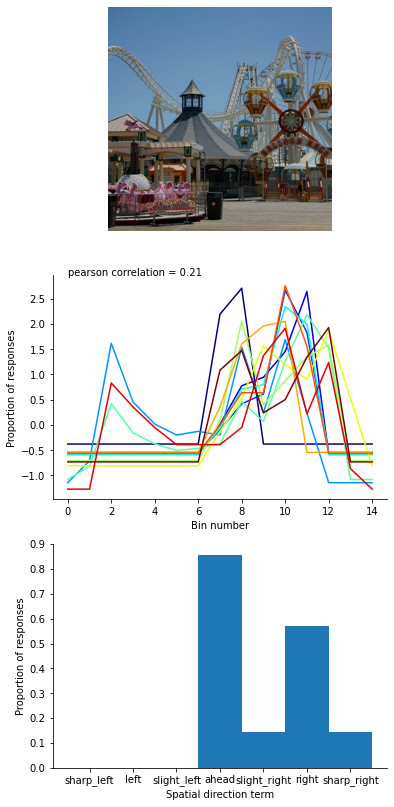

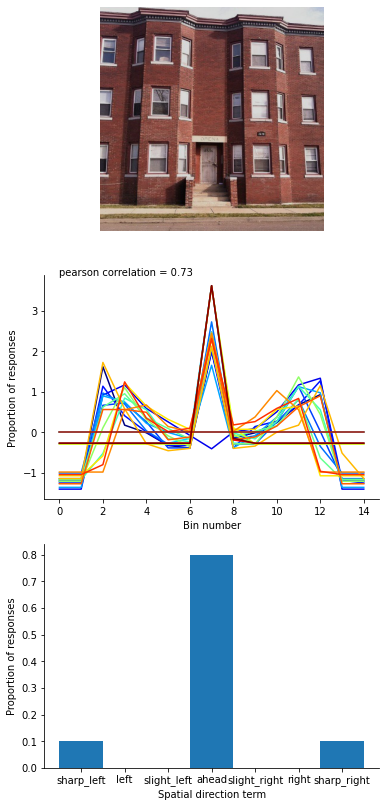

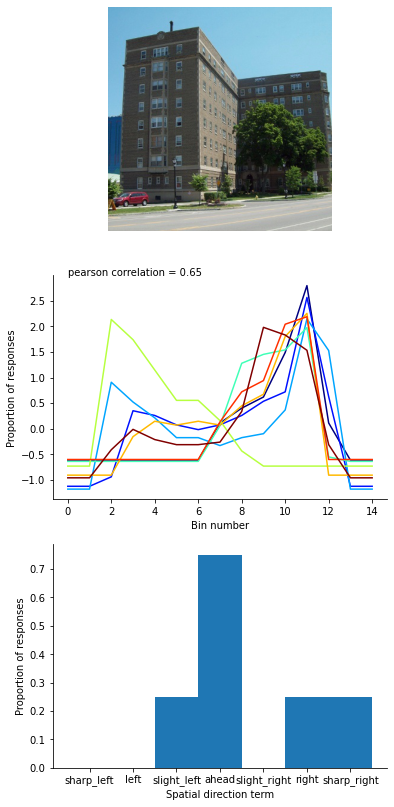

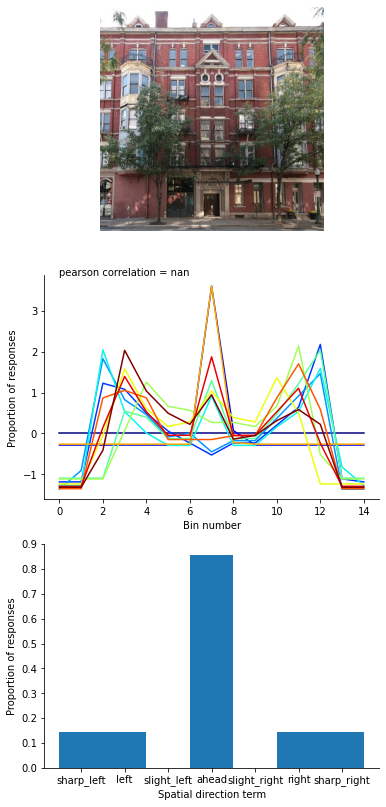

In [41]:

# Get all unique image names
method = 'pearson'
images = all_data.index.unique(level=1)
corr_values = np.zeros_like(images)
for i in range(20):
    corr_values[i] = process_tuning_curves(images[i],
                                           all_data,
                                           ling_data,
                                           show_plots=True,
                                           save_plots=False,
                                           out_dir='/blue/stevenweisberg/share/catscenes/Hoorish_playground/ind_sub_plots_jet_16_bins',
                                           method=method)


# Pretty up the figures :) 
# Generate varied tuning curves! 

0.5552400000000006


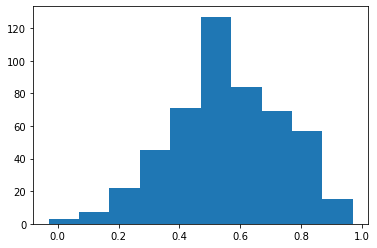

In [36]:
plt.hist(corr_values)
print(corr_values.mean())